In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sto_density import *
from scipy.fftpack import fft 
from tqdm import tqdm
from matplotlib import cm

### Parameter sweep (don't run this part -- just run the part that loads the saved data)

In [2]:
kappa = 1
n = 6
tau = 8.6*2
epsilon = 8.6/2
mu = 1.2
nu = 1.2

T = 5e3
dt = 1e-2
sigma = 1e-3
n_batches = int(T)

N = 40

epsilons = np.linspace(2, 10, N)
taus = np.linspace(10, 30, N)
freqs = np.empty((N, N))
amps = np.empty((N, N))



for (i, epsilon) in tqdm(enumerate(epsilons)): 
    for (j, tau) in enumerate(taus):
        m = density_field_model(mu, nu, kappa, n, tau, epsilon)
        m.initialise(T, dt, n_batches, 1.2, sigma)
        m.evolve() 
        
        y = np.copy(m.psi[-200:]).flatten() 
        y_k = np.abs(np.fft.rfft(y)[1:])
        
        freqs[i, j] = y_k.argmax()
        amps[i, j] = y_k.max() 

0it [00:07, ?it/s]


KeyboardInterrupt: 

In [9]:
np.save('Sims/freqs.npy', freqs)
np.save('Sims/amps.npy', amps)

In [6]:
freqs = np.load('Sims/freqs.npy')
amps = np.load('Sims/amps.npy')

0.2007722007722008 1.2682926829268293


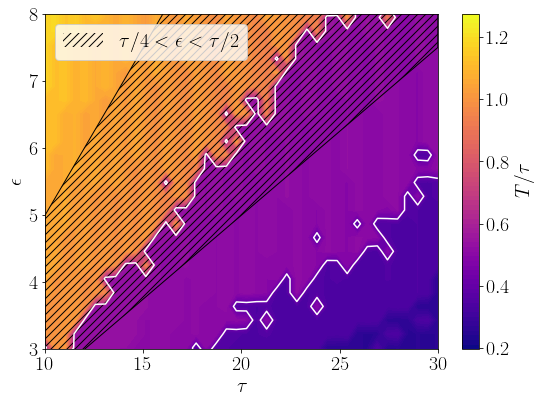

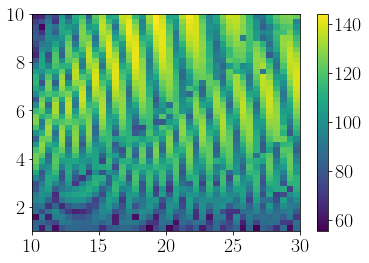

In [30]:
image = (200/(freqs+1)/taus[np.newaxis, :])[1:-1, :]
vmin = np.amin(image)
vmax = np.amax(image)
print(vmin, vmax)

plt.rc('font', size=20)
plt.rc('text', usetex=True)

plt.figure(figsize=(8, 6))

plt.contourf(taus, epsilons[1:-1], image, vmin=vmin, vmax=vmax, cmap='plasma', levels=100)
plt.colorbar(ticks=[0.2, 0.4, 0.6, 0.8, 1, 1.2], label=r'$T/\tau$') 
plt.contour(taus, epsilons[1:-1], image, levels=[0.4, 0.6], colors='white')
plt.fill_between(taus, taus*0.25, taus*0.5, hatch='///', facecolor='None', label=r'$\tau/4 < \epsilon < \tau / 2$')
plt.legend(loc='upper left')
plt.xlim([10, 30])
plt.ylim([3, 8])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\epsilon$')
plt.tight_layout()
plt.savefig('Figures/period.pdf')
plt.show() 

plt.imshow(amps[1:, :], extent=[10, 30, 1, 10], aspect='auto', origin='lower')
plt.colorbar() 
plt.show() 

### Plot graphs at the biologically relevant parameters

In [4]:
tau = 8.6*2
epsilon = 8.6/2
sigma = 1e-3
mu = 1.2
nu = 1.2
kappa = 1
n = 6
T = 1e3
dt = 1e-2
n_frames = int(T*5)
m = density_field_model(mu, nu, kappa, n, tau, epsilon)
m.initialise(T, dt, n_frames, 1.2, sigma)
m.evolve(True) 

time taken:  0.8150980472564697


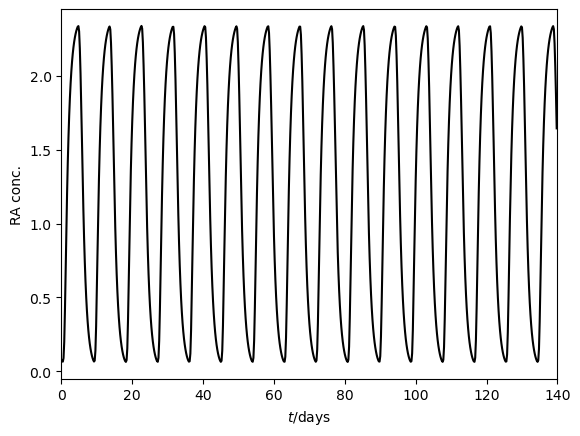

In [5]:
start = 1800
stop = 2500

t = np.arange(0, (stop-start)*0.2, 0.2)
plt.plot(t, m.psi[start:stop],'k')
plt.xlim([0, (stop-start)*0.2])
plt.xlabel(r'$t$/days')
plt.ylabel('RA conc.')
plt.savefig('Figures/ra.pdf')
plt.show() 

### Run simulations with different initial conditions

time taken:  0.15004205703735352
time taken:  0.14512014389038086
time taken:  0.1894981861114502


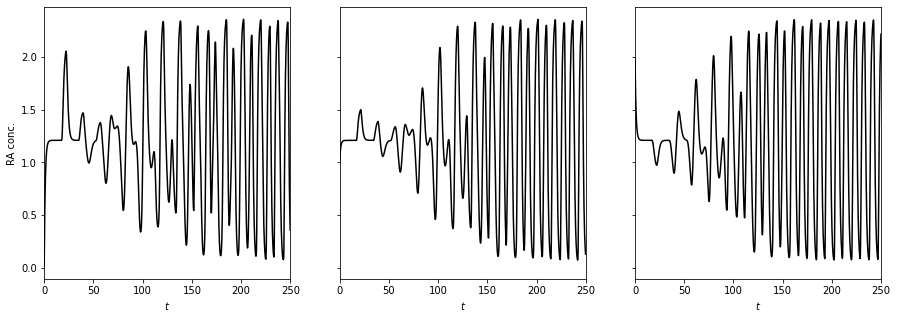

In [46]:
tau = 8.6*2
epsilon = 8.6/2
sigma = 1e-3
mu = 1.2
nu = 1.2
kappa = 1
n = 6
T = 250
dt = 1e-2
n_frames = int(T*5)

cmap = cm.get_cmap('copper')
start = 0
stop = 2000

fig, axes = plt.subplots(1, 3,figsize=(15, 5), sharex=True, sharey=True)

for (i, psi0) in enumerate([0, 1, 2]):
    
    m = density_field_model(mu, nu, kappa, n, tau, epsilon)
    m.initialise(T, dt, n_frames, psi0, sigma)
    m.evolve(True) 

    t = np.arange(0, T, 0.2)
    axes[i].plot(t, m.psi, color='k')
    axes[i].set_xlabel(r'$t$')
axes[0].set_xlim([0, T])
axes[0].set_ylabel('RA conc.')
plt.savefig('Figures/ra_multiple_inits.pdf')
plt.show()

### Run simulations with RA pulses with different periods. Pulses are defined as modifying RA production rate.

time taken:  0.17640209197998047
time taken:  0.1734447479248047
time taken:  0.21564006805419922
time taken:  0.23304414749145508


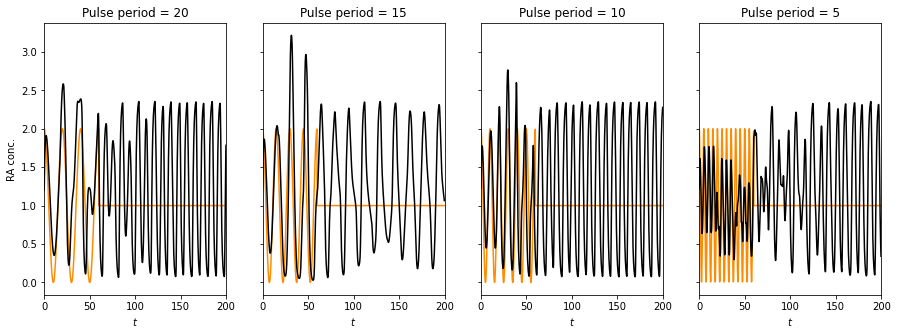

In [55]:
tau = 8.6*2
epsilon = 8.6/2
sigma = 1e-2
mu = 1.2
nu = 1.2
kappa = 1
n = 6
T = 200
dt = 1e-2
n_frames = int(T*5)
psi0=1.2

pulse_time = 60
pulse_periods = [20, 15, 10, 5]

fig, axes = plt.subplots(1, len(pulse_periods),figsize=(15, 5), sharex=True, sharey=True)

for (i, pulse_period) in enumerate(pulse_periods):
    pulses = lambda t: 1+np.heaviside(pulse_time-t, 0)*(np.cos(t*2*np.pi/pulse_period))
    
    m = density_field_model(mu, nu, kappa, n, tau, epsilon)
    m.initialise(T, dt, n_frames, psi0, sigma, pulses)
    m.evolve(True) 

    t = np.arange(0, T, 0.2)
    axes[i].plot(t, pulses(t), color='darkorange')
    axes[i].plot(t, m.psi, color='k')
    axes[i].set_title('Pulse period = {}'.format(pulse_period))
    axes[i].set_xlabel(r'$t$')
axes[0].set_xlim([0, T])
axes[0].set_ylabel('RA conc.')
plt.savefig('Figures/ra_pulse_inits.pdf')
plt.show()

### Alternative time delaying model (just ignore this part)

In [9]:
n = 4
tau = 10
mu = 5/tau
nu = 5/tau
kappa = 1


T = 5e2
dt = 1e-2
sigma = 0
n_batches = int(T)


m = aging_model(mu, nu, kappa, n, tau)
m.initialise(T, dt, n_batches, sigma)
m.evolve() 

time taken:  2.148705005645752


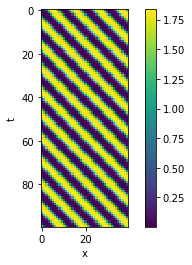

In [10]:
plt.imshow(m.psi[-100:, ::100])
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar() 
plt.show() 